# Ο Πέτρος και ο Λύκος: Εισαγωγή στη Μάθηση Ενίσχυσης

Σε αυτό το σεμινάριο, θα μάθουμε πώς να εφαρμόσουμε τη μάθηση ενίσχυσης σε ένα πρόβλημα εύρεσης διαδρομής. Το σκηνικό είναι εμπνευσμένο από το μουσικό παραμύθι [Ο Πέτρος και ο Λύκος](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) του Ρώσου συνθέτη [Σεργκέι Προκόφιεφ](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Είναι η ιστορία του νεαρού πρωτοπόρου Πέτρου, που θαρραλέα βγαίνει από το σπίτι του στο ξέφωτο του δάσους για να κυνηγήσει τον λύκο. Θα εκπαιδεύσουμε αλγορίθμους μηχανικής μάθησης που θα βοηθήσουν τον Πέτρο να εξερευνήσει την γύρω περιοχή και να δημιουργήσει έναν βέλτιστο χάρτη πλοήγησης.

Πρώτα, ας εισάγουμε μια σειρά από χρήσιμες βιβλιοθήκες:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Επισκόπηση της Ενισχυτικής Μάθησης

Η **Ενισχυτική Μάθηση** (RL) είναι μια τεχνική μάθησης που μας επιτρέπει να μάθουμε τη βέλτιστη συμπεριφορά ενός **πράκτορα** σε κάποιο **περιβάλλον** μέσω της διεξαγωγής πολλών πειραμάτων. Ένας πράκτορας σε αυτό το περιβάλλον πρέπει να έχει κάποιο **στόχο**, ο οποίος ορίζεται από μια **συνάρτηση ανταμοιβής**.

## Το Περιβάλλον

Για λόγους απλότητας, ας θεωρήσουμε ότι ο κόσμος του Πέτρου είναι μια τετράγωνη επιφάνεια μεγέθους `width` x `height`. Κάθε κελί σε αυτή την επιφάνεια μπορεί να είναι:
* **έδαφος**, πάνω στο οποίο ο Πέτρος και άλλα πλάσματα μπορούν να περπατήσουν
* **νερό**, πάνω στο οποίο προφανώς δεν μπορείς να περπατήσεις
* **ένα δέντρο** ή **γρασίδι** - ένα μέρος όπου μπορείς να ξεκουραστείς
* **ένα μήλο**, που αντιπροσωπεύει κάτι που ο Πέτρος θα χαρεί να βρει για να τραφεί
* **ένας λύκος**, που είναι επικίνδυνος και πρέπει να αποφεύγεται

Για να δουλέψουμε με το περιβάλλον, θα ορίσουμε μια κλάση που ονομάζεται `Board`. Για να μην γεμίσουμε υπερβολικά αυτό το σημειωματάριο, έχουμε μεταφέρει όλο τον κώδικα που αφορά την επιφάνεια σε ένα ξεχωριστό module, το `rlboard`, το οποίο θα εισάγουμε τώρα. Μπορείτε να δείτε μέσα σε αυτό το module για περισσότερες λεπτομέρειες σχετικά με την εσωτερική υλοποίηση.


In [2]:
from rlboard import *

Ας δημιουργήσουμε τώρα έναν τυχαίο πίνακα και να δούμε πώς φαίνεται:


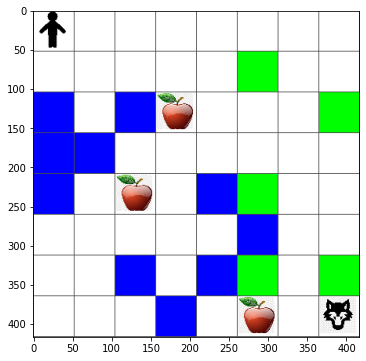

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Ενέργειες και Πολιτική

Στο παράδειγμά μας, ο στόχος του Πέτρου είναι να βρει ένα μήλο, αποφεύγοντας τον λύκο και άλλα εμπόδια. Για να το πετύχει αυτό, μπορεί ουσιαστικά να περπατάει μέχρι να βρει ένα μήλο. Επομένως, σε οποιαδήποτε θέση μπορεί να επιλέξει μία από τις παρακάτω ενέργειες: πάνω, κάτω, αριστερά και δεξιά. Θα ορίσουμε αυτές τις ενέργειες ως ένα λεξικό και θα τις αντιστοιχίσουμε σε ζεύγη αντίστοιχων αλλαγών συντεταγμένων. Για παράδειγμα, η κίνηση προς τα δεξιά (`R`) θα αντιστοιχούσε στο ζεύγος `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Η στρατηγική του πράκτορά μας (Πέτρος) ορίζεται από μια αποκαλούμενη **πολιτική**. Ας εξετάσουμε την απλούστερη πολιτική που ονομάζεται **τυχαία περιπλάνηση**.

## Τυχαία περιπλάνηση

Ας λύσουμε πρώτα το πρόβλημά μας υλοποιώντας μια στρατηγική τυχαίας περιπλάνησης.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Ας εκτελέσουμε το πείραμα τυχαίας περιπλάνησης αρκετές φορές και ας δούμε τον μέσο όρο των βημάτων που έγιναν:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Συνάρτηση Ανταμοιβής

Για να κάνουμε την πολιτική μας πιο έξυπνη, πρέπει να κατανοήσουμε ποιες κινήσεις είναι "καλύτερες" από άλλες.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Δημιουργήστε έναν Πίνακα Q, ή έναν πολυδιάστατο πίνακα. Εφόσον ο πίνακάς μας έχει διαστάσεις `width` x `height`, μπορούμε να αναπαραστήσουμε τον Πίνακα Q με έναν numpy πίνακα με σχήμα `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Περάστε τον Πίνακα-Q στη συνάρτηση σχεδίασης για να οπτικοποιήσετε τον πίνακα στον πίνακα:


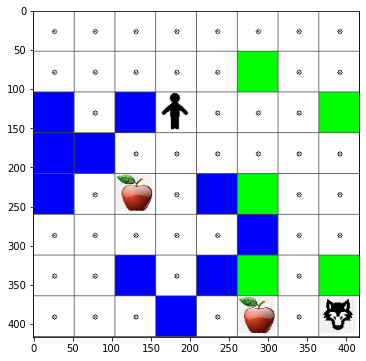

In [9]:
m.plot(Q)

## Ουσία του Q-Learning: Εξίσωση Bellman και Αλγόριθμος Μάθησης

Γράψτε ψευδοκώδικα για τον αλγόριθμο μάθησης:

* Αρχικοποιήστε τον Πίνακα Q (Q-Table) Q με ίσες τιμές για όλες τις καταστάσεις και ενέργειες
* Ορίστε τον ρυθμό μάθησης $\alpha\leftarrow 1$
* Επαναλάβετε τη διαδικασία προσομοίωσης πολλές φορές
   1. Ξεκινήστε από μια τυχαία θέση
   1. Επαναλάβετε
        1. Επιλέξτε μια ενέργεια $a$ στην κατάσταση $s$
        2. Εκτελέστε την ενέργεια μεταβαίνοντας σε μια νέα κατάσταση $s'$
        3. Αν συναντήσουμε συνθήκη τέλους παιχνιδιού ή αν η συνολική ανταμοιβή είναι πολύ μικρή - τερματίστε την προσομοίωση  
        4. Υπολογίστε την ανταμοιβή $r$ στη νέα κατάσταση
        5. Ενημερώστε τη Συνάρτηση Q σύμφωνα με την εξίσωση Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Ενημερώστε τη συνολική ανταμοιβή και μειώστε το $\alpha$.

## Εκμετάλλευση vs. Εξερεύνηση

Η καλύτερη προσέγγιση είναι να ισορροπήσουμε μεταξύ εξερεύνησης και εκμετάλλευσης. Καθώς μαθαίνουμε περισσότερα για το περιβάλλον μας, είναι πιο πιθανό να ακολουθήσουμε τη βέλτιστη διαδρομή, ωστόσο, επιλέγοντας τον ανεξερεύνητο δρόμο περιστασιακά.

## Υλοποίηση σε Python

Τώρα είμαστε έτοιμοι να υλοποιήσουμε τον αλγόριθμο μάθησης. Πριν από αυτό, χρειαζόμαστε επίσης μια συνάρτηση που θα μετατρέπει αυθαίρετους αριθμούς στον Πίνακα Q (Q-Table) σε ένα διάνυσμα πιθανοτήτων για τις αντίστοιχες ενέργειες:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Προσθέτουμε μια μικρή ποσότητα `eps` στον αρχικό διάνυσμα για να αποφύγουμε τη διαίρεση με το 0 στην αρχική περίπτωση, όταν όλα τα στοιχεία του διανύσματος είναι ίδια.

Ο πραγματικός αλγόριθμος εκμάθησης που θα εκτελέσουμε για 5000 πειράματα, επίσης γνωστά ως **εποχές**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Μετά την εκτέλεση αυτού του αλγορίθμου, ο Πίνακας-Q θα πρέπει να ενημερωθεί με τιμές που ορίζουν την ελκυστικότητα των διαφορετικών ενεργειών σε κάθε βήμα. Οπτικοποιήστε τον πίνακα εδώ:


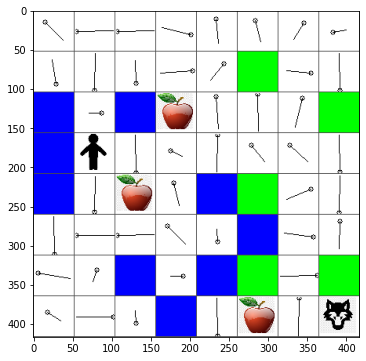

In [12]:
m.plot(Q)

## Έλεγχος της Πολιτικής

Δεδομένου ότι ο Πίνακας Q καταγράφει την "ελκυστικότητα" κάθε ενέργειας σε κάθε κατάσταση, είναι αρκετά εύκολο να τον χρησιμοποιήσουμε για να ορίσουμε την αποτελεσματική πλοήγηση στον κόσμο μας. Στην πιο απλή περίπτωση, μπορούμε απλώς να επιλέξουμε την ενέργεια που αντιστοιχεί στη μεγαλύτερη τιμή του Πίνακα Q:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Αν δοκιμάσετε τον παραπάνω κώδικα αρκετές φορές, μπορεί να παρατηρήσετε ότι κάποιες φορές απλώς "κολλάει" και χρειάζεται να πατήσετε το κουμπί STOP στο notebook για να τον διακόψετε.

> **Εργασία 1:** Τροποποιήστε τη συνάρτηση `walk` ώστε να περιορίσετε το μέγιστο μήκος της διαδρομής σε έναν συγκεκριμένο αριθμό βημάτων (π.χ., 100) και παρακολουθήστε τον παραπάνω κώδικα να επιστρέφει αυτήν την τιμή κατά διαστήματα.

> **Εργασία 2:** Τροποποιήστε τη συνάρτηση `walk` ώστε να μην επιστρέφει σε μέρη όπου έχει ήδη βρεθεί προηγουμένως. Αυτό θα αποτρέψει τη `walk` από το να δημιουργεί βρόχους, ωστόσο, ο πράκτορας μπορεί ακόμα να καταλήξει "παγιδευμένος" σε μια τοποθεσία από την οποία δεν μπορεί να ξεφύγει.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


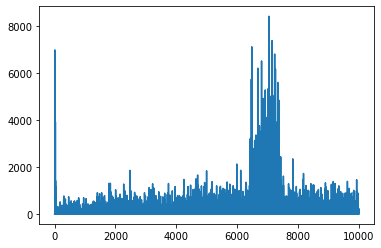

In [15]:
plt.plot(lpath)

Αυτό που παρατηρούμε εδώ είναι ότι αρχικά το μέσο μήκος της διαδρομής αυξήθηκε. Αυτό πιθανότατα οφείλεται στο γεγονός ότι όταν δεν γνωρίζουμε τίποτα για το περιβάλλον, είναι πιο πιθανό να παγιδευτούμε σε κακές καταστάσεις, όπως το νερό ή ο λύκος. Καθώς μαθαίνουμε περισσότερα και αρχίζουμε να χρησιμοποιούμε αυτή τη γνώση, μπορούμε να εξερευνήσουμε το περιβάλλον για μεγαλύτερο χρονικό διάστημα, αλλά ακόμα δεν γνωρίζουμε καλά πού βρίσκονται τα μήλα.

Μόλις μάθουμε αρκετά, γίνεται πιο εύκολο για τον πράκτορα να πετύχει τον στόχο, και το μήκος της διαδρομής αρχίζει να μειώνεται. Ωστόσο, παραμένουμε ανοιχτοί στην εξερεύνηση, οπότε συχνά αποκλίνουμε από την καλύτερη διαδρομή και εξερευνούμε νέες επιλογές, κάνοντας τη διαδρομή μεγαλύτερη από την ιδανική.

Αυτό που παρατηρούμε επίσης σε αυτό το γράφημα είναι ότι σε κάποιο σημείο το μήκος αυξήθηκε απότομα. Αυτό υποδεικνύει τη στοχαστική φύση της διαδικασίας και ότι μπορούμε σε κάποιο σημείο να "χαλάσουμε" τους συντελεστές του Q-Table, αντικαθιστώντας τους με νέες τιμές. Ιδανικά, αυτό θα πρέπει να ελαχιστοποιηθεί μειώνοντας τον ρυθμό εκμάθησης (δηλαδή προς το τέλος της εκπαίδευσης, προσαρμόζουμε τις τιμές του Q-Table μόνο κατά μια μικρή τιμή).

Συνολικά, είναι σημαντικό να θυμόμαστε ότι η επιτυχία και η ποιότητα της διαδικασίας εκμάθησης εξαρτώνται σημαντικά από παραμέτρους, όπως ο ρυθμός εκμάθησης, η μείωση του ρυθμού εκμάθησης και ο συντελεστής έκπτωσης. Αυτές συχνά ονομάζονται **υπερπαράμετροι**, για να διαχωριστούν από τις **παραμέτρους** που βελτιστοποιούμε κατά την εκπαίδευση (π.χ. συντελεστές του Q-Table). Η διαδικασία εύρεσης των καλύτερων τιμών για τις υπερπαραμέτρους ονομάζεται **βελτιστοποίηση υπερπαραμέτρων**, και αξίζει να αποτελέσει ξεχωριστό θέμα.


## Άσκηση
#### Ένας Πιο Ρεαλιστικός Κόσμος του Πέτρου και του Λύκου

Στην περίπτωσή μας, ο Πέτρος μπορούσε να κινείται σχεδόν χωρίς να κουράζεται ή να πεινάει. Σε έναν πιο ρεαλιστικό κόσμο, πρέπει να κάθεται και να ξεκουράζεται από καιρό σε καιρό, καθώς και να τρέφεται. Ας κάνουμε τον κόσμο μας πιο ρεαλιστικό εφαρμόζοντας τους εξής κανόνες:

1. Μετακινούμενος από ένα μέρος σε άλλο, ο Πέτρος χάνει **ενέργεια** και αποκτά **κούραση**.
2. Ο Πέτρος μπορεί να αποκτήσει περισσότερη ενέργεια τρώγοντας μήλα.
3. Ο Πέτρος μπορεί να απαλλαγεί από την κούραση ξεκουραζόμενος κάτω από το δέντρο ή στο γρασίδι (δηλαδή περπατώντας σε ένα σημείο του πίνακα που έχει δέντρο ή γρασίδι - πράσινο πεδίο).
4. Ο Πέτρος πρέπει να βρει και να σκοτώσει τον λύκο.
5. Για να σκοτώσει τον λύκο, ο Πέτρος πρέπει να έχει συγκεκριμένα επίπεδα ενέργειας και κούρασης, διαφορετικά χάνει τη μάχη.

Τροποποιήστε τη συνάρτηση ανταμοιβής σύμφωνα με τους κανόνες του παιχνιδιού, εκτελέστε τον αλγόριθμο ενισχυτικής μάθησης για να μάθετε την καλύτερη στρατηγική για να κερδίσετε το παιχνίδι και συγκρίνετε τα αποτελέσματα της τυχαίας περιήγησης με τον αλγόριθμό σας όσον αφορά τον αριθμό των παιχνιδιών που κερδήθηκαν και χάθηκαν.

> **Σημείωση**: Ίσως χρειαστεί να προσαρμόσετε τις υπερπαραμέτρους για να λειτουργήσει, ειδικά τον αριθμό των εποχών. Επειδή η επιτυχία του παιχνιδιού (η μάχη με τον λύκο) είναι ένα σπάνιο γεγονός, μπορείτε να περιμένετε πολύ μεγαλύτερο χρόνο εκπαίδευσης.



---

**Αποποίηση ευθύνης**:  
Αυτό το έγγραφο έχει μεταφραστεί χρησιμοποιώντας την υπηρεσία αυτόματης μετάφρασης [Co-op Translator](https://github.com/Azure/co-op-translator). Παρόλο που καταβάλλουμε προσπάθειες για ακρίβεια, παρακαλούμε να έχετε υπόψη ότι οι αυτόματες μεταφράσεις ενδέχεται να περιέχουν σφάλματα ή ανακρίβειες. Το πρωτότυπο έγγραφο στη μητρική του γλώσσα θα πρέπει να θεωρείται η αυθεντική πηγή. Για κρίσιμες πληροφορίες, συνιστάται επαγγελματική ανθρώπινη μετάφραση. Δεν φέρουμε ευθύνη για τυχόν παρεξηγήσεις ή εσφαλμένες ερμηνείες που προκύπτουν από τη χρήση αυτής της μετάφρασης.
